In [2]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

/usr/local/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [3]:
df_wheel = pd.read_csv('data/WHEEL.csv')
df_cam = pd.read_csv('data/CAMERA.csv')

In [4]:
def subtract_from_prev_val(df, col, init_val=0):
    return (df[col] - df.shift()[col])
def integrate_col(df, fxdx_col, dx_col, init_val):
    """
    Numeric integration from a panda data frame.
    Uses simply box method
    """
    fxdx_l = df[fxdx_col].tolist()
    dx_l = df[dx_col].tolist()
    prev_val = init_val
    y = [init_val]*len(df)
    for i in xrange(len(df)):
        y_val = prev_val + float(dx_l[i]) * fxdx_l[i]
        y[i] = y_val
        prev_val = y_val
        
    return np.array(y)

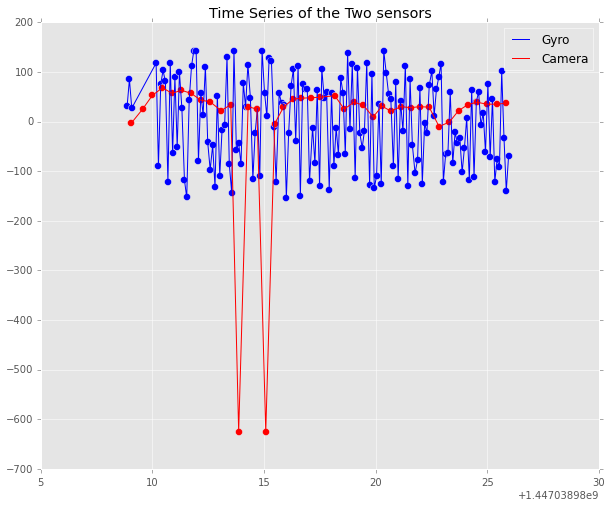

In [14]:
plt.figure().set_size_inches(10, 8)
plt.plot(df_wheel['timestamp'], df_wheel['gz'] - df_wheel['gz'].mean(), c = 'blue', label='Gyro' )
plt.scatter(df_wheel['timestamp'], df_wheel['gz'] - df_wheel['gz'].mean(), c = 'blue', s=50 )
plt.plot(df_cam['timestamp'], df_cam['faceX'] - df_cam['faceX'].mean(), c='red', label='Camera')
plt.scatter(df_cam['timestamp'], df_cam['faceX'] - df_cam['faceX'].mean(), c='red',s=50)
plt.title('Time Series of the Two sensors')
plt.legend()

In [22]:
df_wheel['timediff'] = subtract_from_prev_val(df_wheel, 'timestamp')
df_cam['timediff'] = subtract_from_prev_val(df_cam, 'timestamp')

In [25]:
import sklearn.neighbors  as neighbors  
def fuse_data(df_base, df_inject, distance_col):
    """
    Assumes one data set is more dense than the other, and will inject
    the sparse dataset into the dense one
    """
    index_b = df_base.index
    distance_b = df_base[distance_col]
    df_base['dummy_index'] = index_b
    # slower one
    index_i = df_inject.index
    distance_i = df_inject[distance_col].reshape(len(df_inject),1)
    df_inject['dummy_index'] = index_i
    fused_index = []
    ann = neighbors.NearestNeighbors()
    ann.fit(distance_i)
    for i in index_b:
        nearest = ann.kneighbors(distance_b[i],1, return_distance=False)
        fused_index.append(dict(
                index_base = i,
                index_inject = nearest[0][0],
                ))
        
    df_fused = pd.DataFrame(fused_index)
    df_ = pd.merge(df_fused, df_base, left_on='index_base', right_on='dummy_index')
    df_.drop('dummy_index', axis = 1, inplace=True)
    df_ = pd.merge(df_, df_inject, left_on ='index_inject', right_on='dummy_index')
    df_.drop(['dummy_index', 'index_base', 'index_inject'], axis = 1, inplace=True)
    return df_
    
fused = fuse_data(df_wheel, df_cam, 'timestamp')

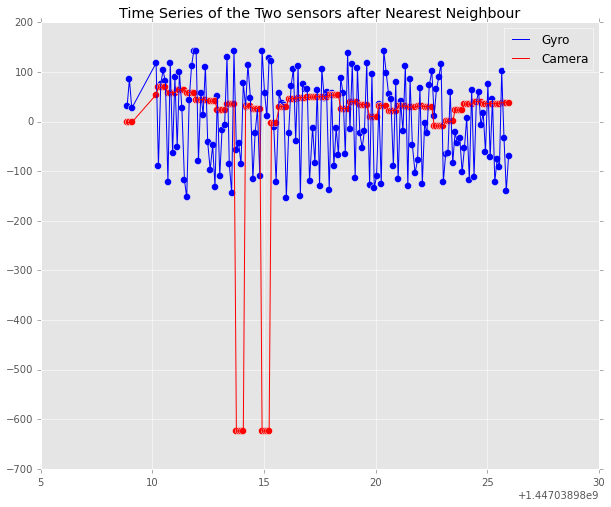

In [17]:
plt.figure().set_size_inches(10, 8)
plt.plot(fused['timestamp_x'], fused['gz'] - fused['gz'].mean(), c = 'blue', label='Gyro' )
plt.scatter(fused['timestamp_x'], fused['gz'] - fused['gz'].mean(), c = 'blue', s =50)
plt.plot(fused['timestamp_x'], fused['faceX'] - fused['faceX'].mean(), c='red', label='Camera')
plt.scatter(fused['timestamp_x'], fused['faceX'] - fused['faceX'].mean(), c='red', s= 50)
plt.title('Time Series of the Two sensors after Nearest Neighbour')
plt.legend()

In [38]:
def metric(df_fused, col, sample_rate):
    v = df_fused[col]
    return np.sum(np.power(v - sample_rate, 2)) / (len(v) - 1)
    
metric(fused[~pd.isnull(fused['timediff_x'])], 'timediff_y' ,0.1)


0.11115418237701814

In [27]:
fused

,Unnamed: 0_x,gz,theta,timestamp_x,timediff_x,Unnamed: 0_y,faceX,faceY,isFrontFace,isRotatedFace,noseX,noseY,time,timestamp_y,timediff_y
0,0,186,2.691493e+11,1.447039e+09,NaN,0,621,394,1,2,-1,-1,1.447039e+09,1.447039e+09,NaN
1,1,239,6.149916e+11,1.447039e+09,0.101220,0,621,394,1,2,-1,-1,1.447039e+09,1.447039e+09,NaN
2,2,181,8.769056e+11,1.447039e+09,0.104505,0,621,394,1,2,-1,-1,1.447039e+09,1.447039e+09,NaN
3,3,272,1.270500e+12,1.447039e+09,1.091301,2,677,382,2,0,-1,-1,1.447039e+09,1.447039e+09,0.440137
4,4,65,1.364558e+12,1.447039e+09,0.104373,3,692,370,2,0,-1,-1,1.447039e+09,1.447039e+09,0.449911
5,5,229,1.695930e+12,1.447039e+09,0.102859,3,692,370,2,0,-1,-1,1.447039e+09,1.447039e+09,0.449911
6,6,257,2.067819e+12,1.447039e+09,0.101977,3,692,370,2,0,-1,-1,1.447039e+09,1.447039e+09,0.449911
7,7,235,2.407873e+12,1.447039e+09,0.107844,3,692,370,2,0,-1,-1,1.447039e+09,1.447039e+09,0.449911
8,8,33,2.455625e+12,1.447039e+09,0.111668,4,681,379,1,0,-1,-1,1.447039e+09,1.447039e+09,0.429083
9,9,272,2.849220e+12,1.447039e+09,0.105451,4,681,379,1,0,-1,-1,1.447039e+09,1.447039e+09,0.429083
